**Previously we saw that :**

* We had some variables not evenly distributed where we could check if some transformations could be useful. `'Avg_Open_To_Buy'`, `'Avg_Utilization_Ratio'`, `'Credit_Limit'`, `'Total_Amt_Chng_Q4_Q1'`, `'Total_Trans_Amt'`.<br> 
<br> 
* We had correlated variables :
    * `Months_on_book` and `Customer_Age`.
    * `Avg_Open_To_Buy` and `Credit_Limit`.
    * `Total_Trans_Ct` and `Total_Trans_Amt`.<br> 
<br> 
* We had see some sort of relationship between `Total_Revolving_Bal` and `Avg_Utilization_Ratio`.<br> 
<br> 

Also by investing our data we found that we had a relationship between 3 of our variables :
* `Avg_Utilization_Ratio` (how much of the available credit the customer spent [%])
* `Credit_Limit` (Credit Limit on the Credit Card)
* `Avg_Open_To_Buy` (the amount left in your credit card to use which hasn't been paid off yet: *Limit - Used amount* ).<br>
<br>

Such that these 3 variables are related like this:

\begin{equation}
\small
\frac{Avg\_Open\_To\_Buy}{Credit\_Limit} + Avg\_Utilization\_Ratio = 1
\end{equation}

This formula just show the equilibrium ( balance ) between used and available credit limit.
Which could be re-written as follow :

\begin{equation}
\small
Avg\_Open\_To\_Buy + Avg\_Utilization\_Ratio * Credit\_Limit = Credit\_Limit
\end{equation}


\begin{equation}
\small
Avg\_Open\_To\_Buy + Avg\_Utilization\_Amount = Credit\_Limit
\end{equation}

`Avg_Open_To_Buy` is what customers have left on their credit limit and `Avg_Utilization_Amount` is what customers have already spent on their credit limit. Finally `Credit_Limit` is just the sum of both.

So we will combine `Avg_Utilization_Ratio` and `Credit_Limit` to get the average amount of credit used over 12 months by the customers. And only keep that new variables out of the 3.

In [1]:
# Data manipulations
import pandas as pd
import numpy as np
from scipy import stats

# Vizualisation
import seaborn as sns
import matplotlib.pyplot as plt
# from pycomp.viz.insights import *
    
# Data transformations
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, power_transform

# Config and support
from support.pipeline import *
from support.utility import * # load_data

# Classifiers
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

imported


In [2]:
def load_data(path, *args, target_var="Attrition_Flag"):
    import pandas as pd
    data = pd.read_csv(path)
    data[target_var] = data[target_var].map({args[0]: True, args[1]: False})
    X, y = data.drop([target_var], axis=1), data[target_var]
    return X, y

In [2]:
features, target = load_data('data/train.csv',"Attrited Customer", "Existing Customer")
CLIENTNUM = features.pop("CLIENTNUM")
df = pd.concat([features,target], axis=1)
df.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
0,48,F,4,Uneducated,Married,Less than $40K,Blue,41,5,3,4,2340.0,1680,660.0,0.791,4751,83,0.804,0.718,False
1,41,F,3,High School,Married,Less than $40K,Blue,31,3,3,3,3952.0,0,3952.0,1.002,8241,82,0.952,0.000,True
2,50,F,2,Uneducated,Single,Less than $40K,Blue,36,5,3,2,1721.0,1037,684.0,0.721,2681,57,0.727,0.603,False
3,44,F,4,Graduate,Married,Unknown,Blue,34,6,4,2,2105.0,0,2105.0,0.656,4190,67,0.914,0.000,False
4,57,M,2,Uneducated,Unknown,$80K - $120K,Blue,48,4,1,3,30543.0,264,30279.0,0.882,7784,63,0.703,0.009,True


We can check the following equation by plotting it for all customers in our data to see if its verified.

\begin{equation}
\frac{Avg\_Open\_To\_Buy}{Credit\_Limit} + Avg\_Utilization\_Ratio = 1
\end{equation}

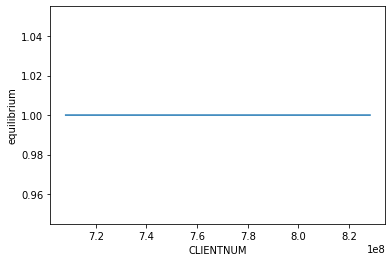

In [4]:
equilibrium = pd.Series((df['Avg_Open_To_Buy'] / df['Credit_Limit']) + df['Avg_Utilization_Ratio'], name="equilibrium")
sns.lineplot(x=CLIENTNUM, y=round(equilibrium,3))

We can see that our equation is verified as we can see it sum up to 1 for all customers.

Now we will create three variables for later use:

* `Avg_Open_To_Buy` / `Credit_Limit` ( Ratio of Credit available )

* `Avg_Utilization_Ratio` * `Credit_Limit` ( Amount of Credit Used )

* `Total_Trans_Amt` / `Total_Trans_Ct` ( average amount by transaction )

In [5]:
ratio_ft = pd.Series(df['Avg_Open_To_Buy'] / df['Credit_Limit'], name="ratio_ft")
amount_use = pd.Series(df['Avg_Utilization_Ratio'] * df['Credit_Limit'], name="amount_use")
average_transac = pd.Series(df['Total_Trans_Amt'] / df['Total_Trans_Ct'], name="average_transac")

**We will now check the distribution of our features and see how they change with different tranformations :**
* log transform
* box cox
* standard scaler



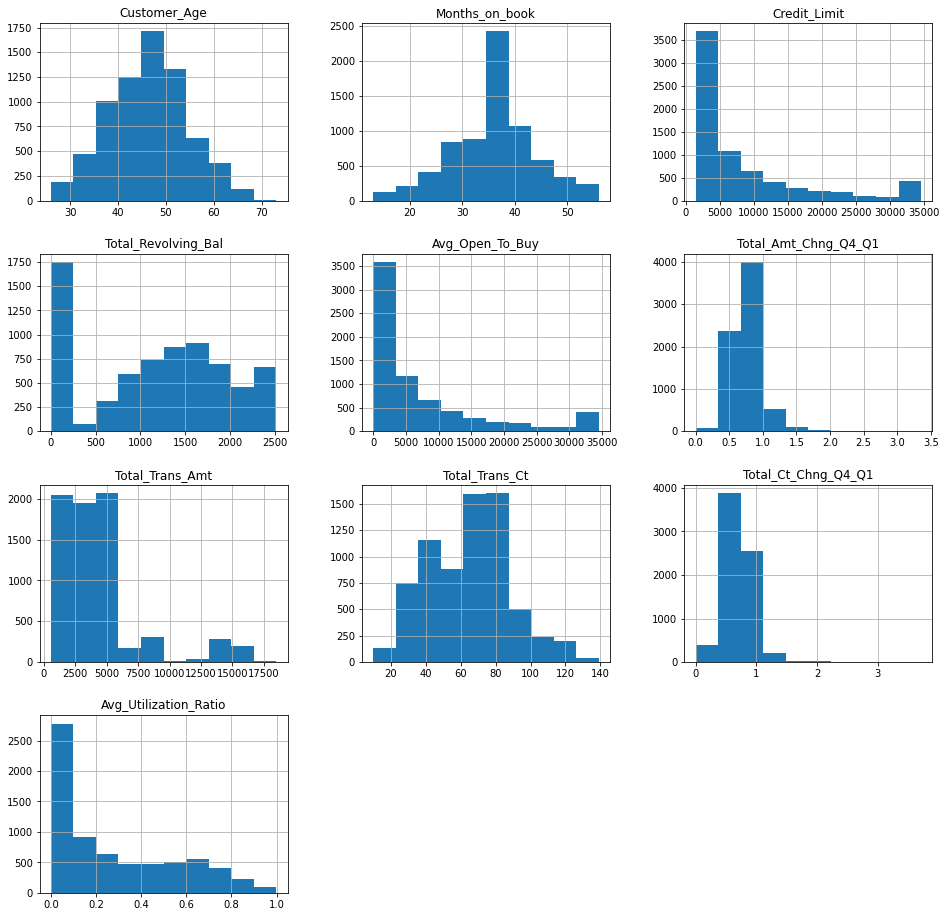

In [6]:
df[NUMERIC_FEATURES].hist(figsize=(16,16));

We will apply transformations on the least evenly distributed features.

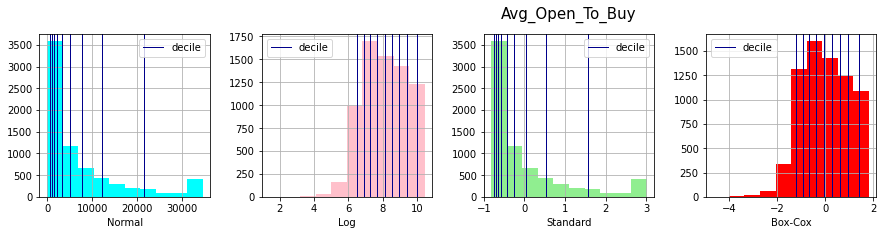

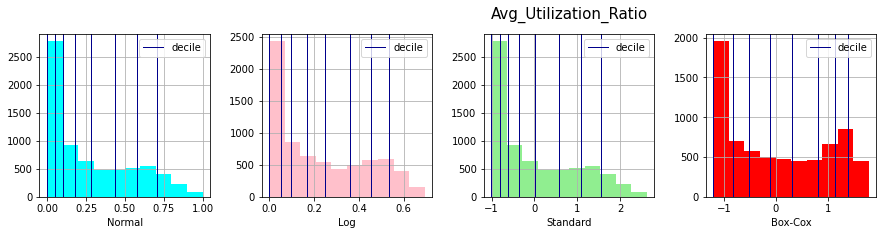

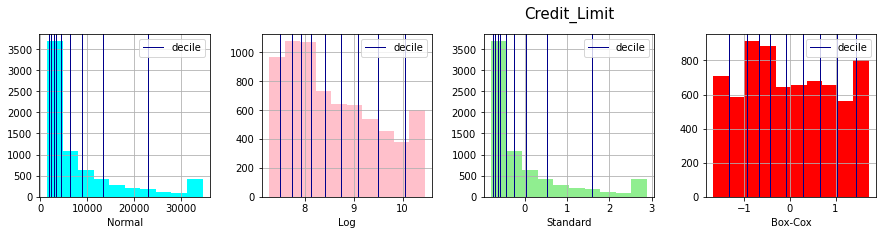

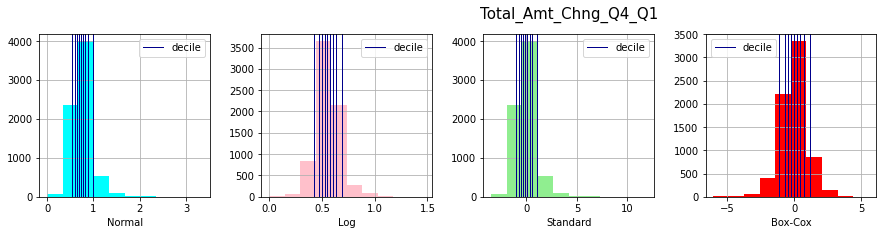

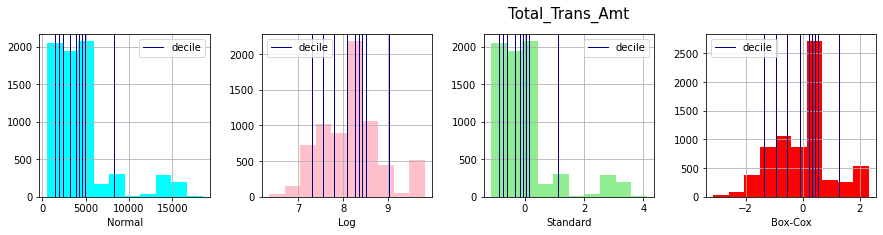

In [7]:
cols =['Avg_Open_To_Buy', 'Avg_Utilization_Ratio', 'Credit_Limit', 'Total_Amt_Chng_Q4_Q1','Total_Trans_Amt']

for col in cols:
    i = 0
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 3))
    
    f1 = df[col]
    f2 = (df[col]+1).transform(np.log)
    f3 = pd.DataFrame(StandardScaler().fit_transform(np.array(df[col]).reshape(-1, 1)))
    f4 = pd.DataFrame(power_transform(np.array(df[col]+1).reshape(-1, 1), method='box-cox'))
#     f5 = pd.DataFrame(power_transform(np.array(df[col]+1).reshape(-1, 1), method='yeo-johnson'))

    
    for column in [[f1, 'cyan', 'Normal'], [f2, 'pink', 'Log'], 
                   [f3, 'lightgreen', 'Standard'], [f4, 'red', 'Box-Cox']]:
        feature = column[0]
        colour = column[1]
        name = column[2]
        
        feature.hist(ax=axes[i], color=colour)
        deciles = feature.quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9])
        
        for pos in np.array(deciles).reshape(1, -1)[0]:
            handle = axes[i].axvline(pos, color='darkblue', linewidth=1)

        axes[i].legend([handle], ['decile'])
        axes[i].set_xlabel(name)
        
        i += 1 
    
    axes[2].set_title(col, fontsize=15, pad=15)
    axes[3].set_title('')
#     axes[4].set_title('')
                    
    plt.show()

plt.show()

From above plot we decide to apply *box-cox* transformation on `Total_Amt_Chng_Q4_Q1` and *log* transformation on `Total_Trans_Amt`.

In [8]:
df['Total_Amt_Chng_Q4_Q1'] = power_transform(np.array(df['Total_Amt_Chng_Q4_Q1']+1).reshape(-1, 1), method='box-cox')
df['Total_Trans_Amt'] = (df['Total_Trans_Amt']+1).transform(np.log)

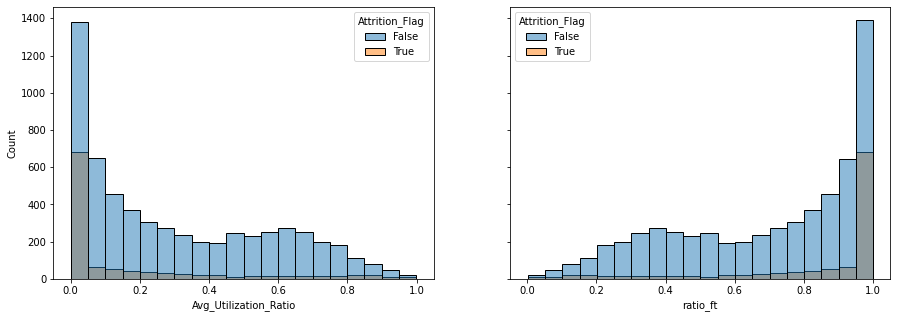

In [10]:
equi_df = pd.concat([df, ratio_ft, amount_use, average_transac], axis=1)
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

sns.histplot(ax=axes[0], data=equi_df, x="Avg_Utilization_Ratio", hue="Attrition_Flag");
sns.histplot(ax=axes[1], data=equi_df, x="ratio_ft", hue="Attrition_Flag");

They are perfectly symmetric in disribution and perfectly correlated. So we will only keep the `Average_Use_Ratio` as they provide the same information. And we will drop `Avg_Open_To_Buy` and `Credit_Limit`

Now we check how our new features relate to existing features.

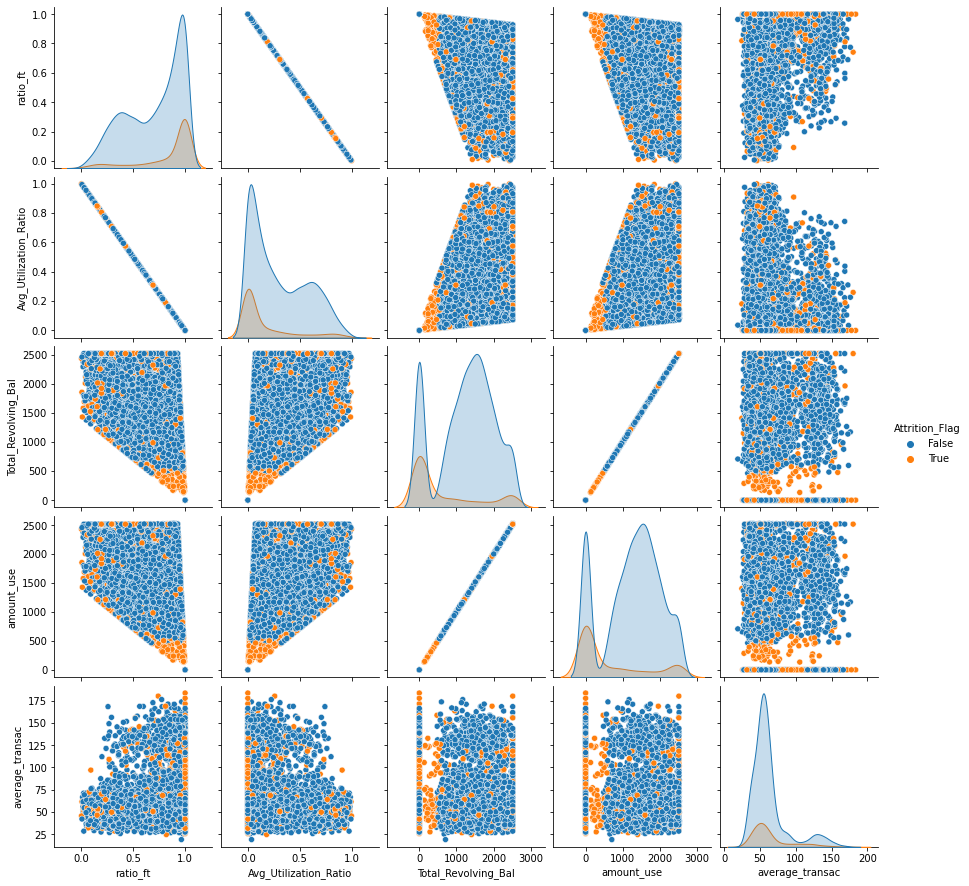

In [11]:
sns.pairplot(equi_df[["ratio_ft", "Avg_Utilization_Ratio","Attrition_Flag", "Total_Revolving_Bal", "amount_use", "average_transac"]], hue="Attrition_Flag");

In this plot we can see that the Amount of Credit Used is perfectly correlated to `Total_Revolving_Bal`, so we will not use this new feature. As we see the `Avg_Utilization_Ratio` is correlated and had a relationship with `Total_Revolving_Bal` through Credit_Limit so we will drop them.

In [12]:
df = df.drop(["Credit_Limit", "Avg_Utilization_Ratio"], axis=1)

We saw that we had high correlations between the following variables. We will look at their distributions and keep the ones we prefer.

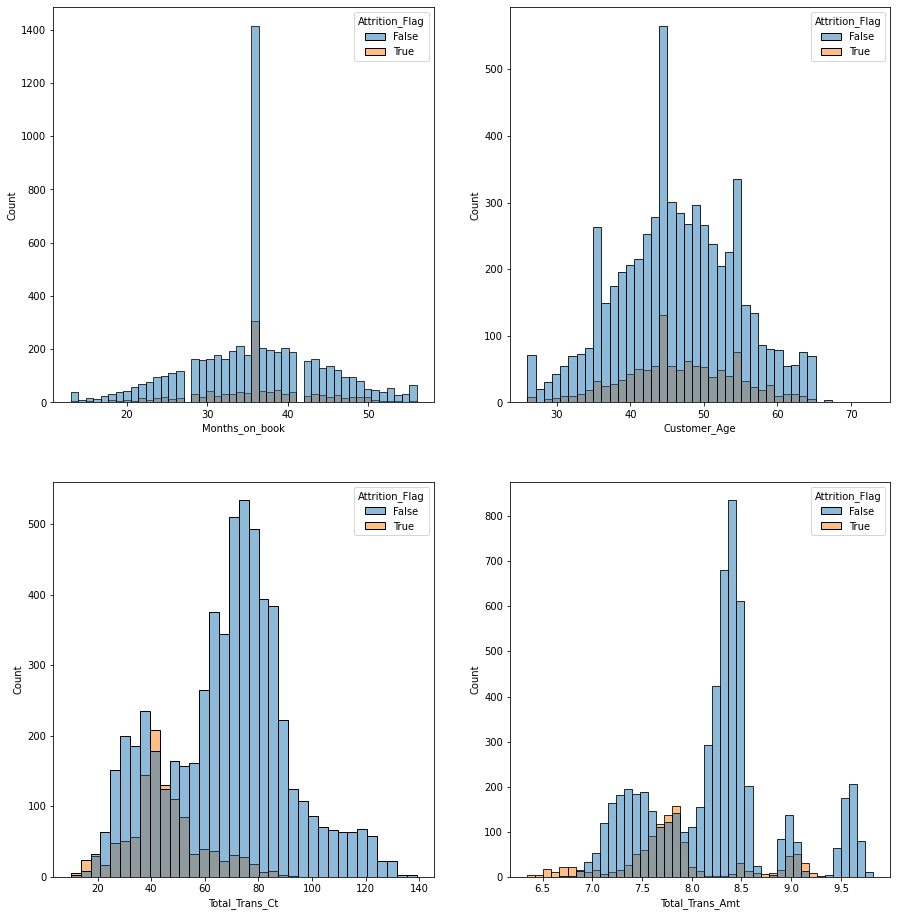

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 16))

sns.histplot(data=df, x="Months_on_book", hue="Attrition_Flag", ax=axes[0,0]);
sns.histplot(data=df, x="Customer_Age", hue="Attrition_Flag", ax=axes[0,1]);
sns.histplot(data=df, x="Total_Trans_Ct", hue="Attrition_Flag", ax=axes[1,0]);
sns.histplot(data=df, x="Total_Trans_Amt", hue="Attrition_Flag", ax=axes[1,1]);

We will drop `Months_on_book` columns for collinearity purpose. But we will keep `Total_Trans_Amt` and `Total_Trans_Ct` as it seems they provide strong predictive power.

In [17]:
df = df.drop(["Months_on_book"], axis=1)

**Now that we now which features to use we can move on the 3rd part to build a pipeline to create and evaluate our model.**